In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from dotenv import load_dotenv
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [4]:
df = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin((
            "acute_citalopram", 
            "acute_saline", 
            "shock", 
            "sham", 
            "acute_cit", 
            "acute_sal"
                ))
        )]
)

In [5]:
df_response = pd.read_csv(data_dir / "psth_responses.csv")

In [6]:
group_names = ["acute_citalopram", "acute_saline", "shock", 
               "sham", "acute_cit", "acute_sal"]
block_name = "base_shock"
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()
session= "hamilton_36"

In [7]:
(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
64,hamilton_36,fast_firing,4
65,hamilton_36,slow_irregular,13
66,hamilton_36,slow_regular,7


In [8]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session]
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)
df_events = (
    select_discrete_data(
        engine, metadata, 
        block_name=block_name,
        group_names=group_names,
    )
    .loc[lambda x: x["session_name"]==session]
    .assign(
        event_s= lambda x: x["timepoint_sample"].divide(fs)
    )
)

In [9]:
"hamilton_36"

'hamilton_36'

In [10]:
df_spikes = df_spikes.merge(df_response[["response_baseshock", "neuron_id", "cluster"]])

In [11]:
from spiketimes.df.conversion import df_to_list


_, inhibs = df_to_list(df_spikes[df_spikes["response_baseshock"] == "Inhibited"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, stims = df_to_list(df_spikes[df_spikes["response_baseshock"] == "Stimulated"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

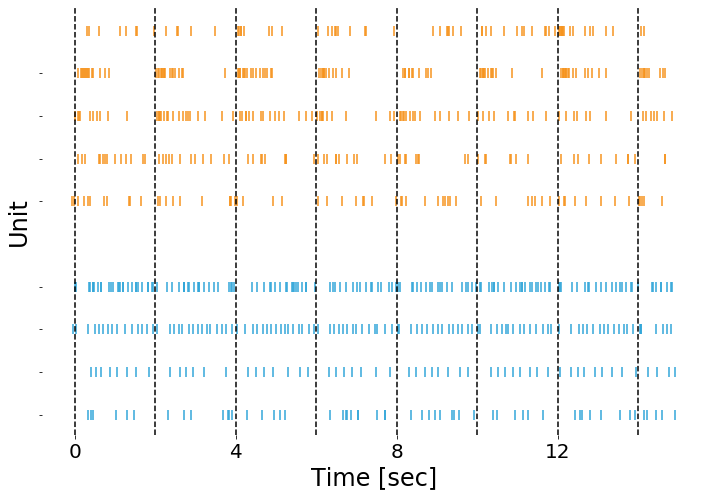

In [12]:
from spiketimes.plots import grouped_raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 7))

t_start = 1900.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = grouped_raster([inhibs, stims[-5:]],
                    ["#31A6D9", "#F6931D"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax)

ax.set_yticks(ticks=[0, 1, 2, 3, 5,6 , 7, 8])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 8, 12], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
# plt.savefig(fig_dir / "psth_raster.svg", transparent=True, dpi=300)

# By Neuron Type

## SR

In [14]:
df_response.loc[lambda x: x.cluster == "slow_regular"].groupby("session_name").response_baseshock.value_counts()

session_name  response_baseshock
hamilton_04   Stimulated             4
hamilton_09   Non Responder          3
              Inhibited              1
hamilton_31   Non Responder         11
              Stimulated             7
hamilton_32   Non Responder          5
              Stimulated             5
              Inhibited              2
hamilton_35   Stimulated            11
              Inhibited              8
              Non Responder          8
hamilton_36   Non Responder          3
              Inhibited              2
              Stimulated             1
hamilton_37   Non Responder         11
              Inhibited              5
              Stimulated             3
hamilton_38   Stimulated             1
Name: response_baseshock, dtype: int64

In [15]:
df

,neuron_id,mean_firing_rate_ifr,mean_firing_rate,cv2_isi,waveform_width,peak_asymmetry,cluster,channel,is_single_unit,session_name,group_name,experiment_name
0,1,0.918980,0.601693,0.467315,16.0,0.065574,slow_regular,6,1,ESHOCK_03_LOC1,shock,ESHOCK
1,4,3.521961,2.105512,0.824797,9.0,0.037344,slow_irregular,17,1,ESHOCK_03_LOC1,shock,ESHOCK
2,5,7.001852,1.778190,0.394575,17.0,0.070539,slow_regular,20,1,ESHOCK_03_LOC1,shock,ESHOCK
3,6,1.620700,0.832163,0.428821,21.0,0.087137,slow_regular,26,1,ESHOCK_03_LOC1,shock,ESHOCK
4,8,5.206785,1.690391,0.305202,70.0,0.343137,slow_regular,28,1,ESHOCK_03_LOC1,shock,ESHOCK
...,...,...,...,...,...,...,...,...,...,...,...,...
580,165,NaN,NaN,NaN,NaN,NaN,no_baseline,7,1,ESHOCK_09_LOC1,sham,ESHOCK
581,183,NaN,NaN,NaN,NaN,NaN,no_baseline,7,1,ESHOCK_09_LOC1,sham,ESHOCK
582,1063,NaN,NaN,NaN,NaN,NaN,no_baseline,23,1,hamilton_09,acute_cit,HAMILTON
583,1753,NaN,NaN,NaN,NaN,NaN,no_baseline,10,1,hamilton_38,acute_cit,HAMILTON


In [84]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)
df_events = (
    select_discrete_data(
        engine, metadata, 
        block_name=block_name,
        group_names=group_names,
    )
    .loc[lambda x: x["session_name"]==session]
    .assign(
        event_s= lambda x: x["timepoint_sample"].divide(fs)
    )
)
df_spikes = (
    df_spikes
    .merge(df_response[["response_baseshock", "neuron_id", "cluster"]]
          )
    .merge(df[["neuron_id", "session_name"]])
)

In [92]:
df_spikes_sub = df_spikes.loc[lambda x: (x.cluster == "slow_regular") &
                             (x.session_name == "hamilton_37")]

_, inhibs = df_to_list(df_spikes_sub[
    df_spikes_sub["response_baseshock"] == "Inhibited"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, stims = df_to_list(df_spikes_sub[df_spikes_sub["response_baseshock"] == "Stimulated"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")


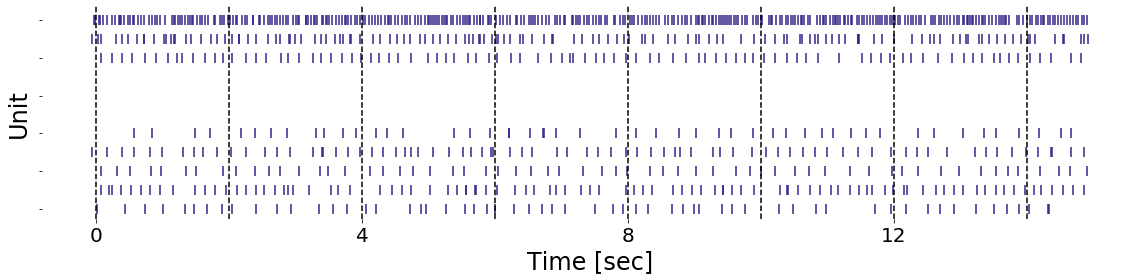

In [93]:
from spiketimes.plots import grouped_raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(16, 4))

t_start = 1910.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = grouped_raster([inhibs, stims[:]],
                    ["#332288", "#332288"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=3,
               plot_kwargs={"s":90},
                   ax=ax)

# ax.set_yticks(ticks=[0, 1, 2, 3, 5,6 , 7, 8])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 8, 12], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()


# plt.savefig(fig_dir / "SR_psth_raster.svg", transparent=True, dpi=300)

## SIR

In [140]:
df_spikes_sub = df_spikes.loc[lambda x: (x.cluster == "slow_irregular") &
                             (x.session_name == "hamilton_36")]

_, inhibs = df_to_list(df_spikes_sub[
    df_spikes_sub["response_baseshock"] == "Inhibited"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, stims = df_to_list(df_spikes_sub[df_spikes_sub["response_baseshock"] == "Stimulated"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

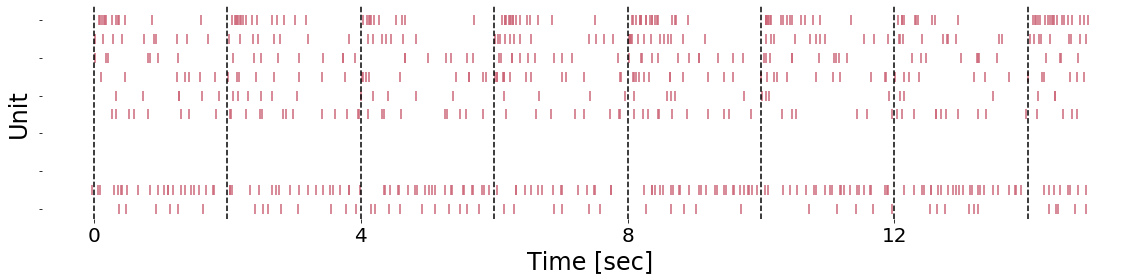

In [141]:
from spiketimes.plots import grouped_raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(16, 4))

t_start = 1910.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = grouped_raster([inhibs, stims[:]],
                    ["#CC6677", "#CC6677"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=3,
               plot_kwargs={"s":90},
                   ax=ax)

# ax.set_yticks(ticks=[0, 1, 2, 3, 5,6 , 7, 8])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 8, 12], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
plt.savefig(fig_dir / "SIR_psth_raster.svg", transparent=True, dpi=300)

## FF

In [142]:
df_spikes_sub = df_spikes.loc[lambda x: (x.cluster == "fast_firing")]

_, inhibs = df_to_list(df_spikes_sub[
    df_spikes_sub["response_baseshock"] == "Inhibited"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, stims = df_to_list(df_spikes_sub[df_spikes_sub["response_baseshock"] == "Stimulated"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

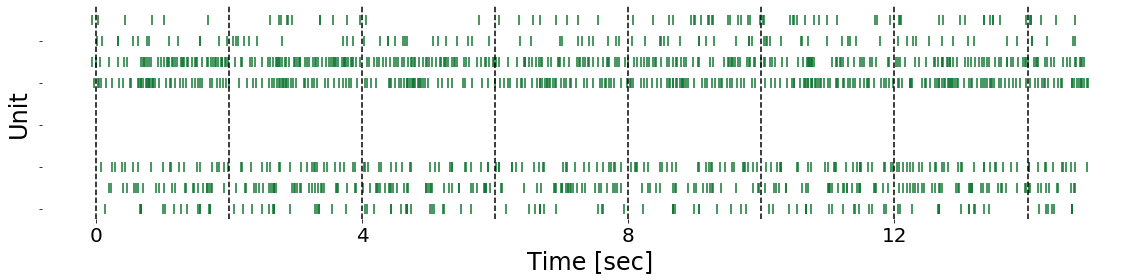

In [144]:
from spiketimes.plots import grouped_raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(16, 4))

t_start = 1850.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = grouped_raster([inhibs, stims[::2]],
                    ["#117733", "#117733"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=3,
               plot_kwargs={"s":90},
                   ax=ax)

# ax.set_yticks(ticks=[0, 1, 2, 3, 5,6 , 7, 8])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 8, 12], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
plt.savefig(fig_dir / "FF_psth_raster.svg", transparent=True, dpi=300)

## NSA

In [27]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

df_spikes = (
    df_spikes
    .merge(df_response[["response_baseshock", "neuron_id", "cluster"]]
          )
    .merge(df[["neuron_id", "session_name"]])
)


df_spikes_sub = df_spikes.loc[lambda x: (x.cluster == "no_baseline")]

_, inhibs = df_to_list(df_spikes_sub[
    df_spikes_sub["response_baseshock"] == "Inhibited"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, stims = df_to_list(df_spikes_sub[df_spikes_sub["response_baseshock"] == "Stimulated"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

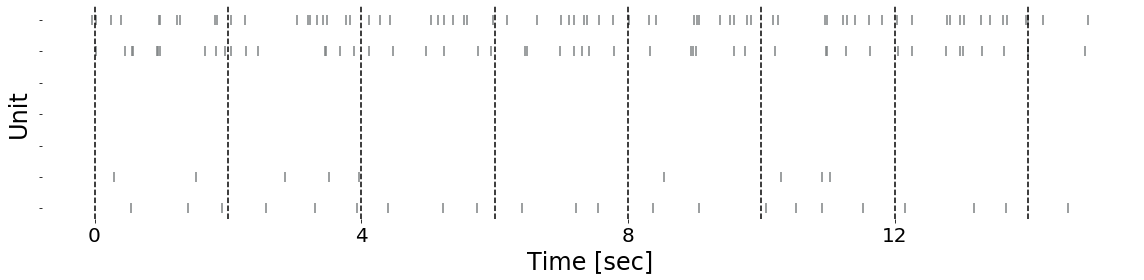

In [40]:
from spiketimes.plots import grouped_raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(16, 4))

t_start = 1890.3
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = grouped_raster([inhibs[::2], stims[1:4:2]],
                    ["#7E8283", "#7E8283"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=3,
               plot_kwargs={"s":90},
                   ax=ax)

# ax.set_yticks(ticks=[0, 1, 2, 3, 5,6 , 7, 8])
ax.set_yticklabels([])

ax.set_xticks(ticks=events[::2])
ax.set_xticklabels([0, 4, 8, 12], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
plt.savefig(fig_dir / "NSA_psth_raster.svg", transparent=True, dpi=300)

In [26]:
df_spikes.cluster.unique()

array(['slow_regular', 'slow_irregular', 'fast_firing', 'no_baseline'],
      dtype=object)